# 3d elastostatics 

Imports:

In [7]:
import os 
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import numpy as np

import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize

Convince JAX to use `float64` and create the random key.

In [8]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)

### Geometry construction

The domain consists of 4 subdomains parametrized using NURBS.

In [9]:
def create_geometry(key, scale = 1):
    R = 2
    r = 1
    Rp = 2
    d = 0.5
    
    knots = np.array( [ [[[r,0,0], [r,0,r], [0,0,r]], [[r,d,0], [r,d,r], [0,d,r]]], [[[R,0,0], [R,0,R], [0,0,R]], [[R,d,0], [R,d,R], [0,d,R]]] ])
    weights = np.ones(knots.shape[:3])
    weights[:,:,1] = 1/np.sqrt(2)
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom1 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    knots = np.array( [[[[0,0,r],[-(R-r),0,r]], [[0,d,r],[-(R-r),d,r]]], [[[0,0,R],[-(R-r),0,R]], [[0,d,R],[-(R-r),d,R]]]] )
    weights = np.ones(knots.shape[:3])
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)

    geom2 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    knots = np.array( [[[[r+Rp,-R,r], [-(R-r),-R,r], [-(R-r),0,r]], [[r+Rp,-r,r], [0,-r,r], [0,0,r]]], [[[r+Rp,-R,R], [-(R-r),-R,R], [-(R-r),0,R]], [[r+Rp,-r,R], [0,-r,R], [0,0,R]]]] )
    knots = np.transpose(knots,[0,2,1,3])
    knots = knots[:,:,::-1,:]
    weights = np.ones(knots.shape[:3])
    weights[:,1,:] = 1/np.sqrt(2)
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom3 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    
    knots = np.array( [[[[r+Rp,R+d,r], [-(R-r),R+d,r], [-(R-r),d,r]], [[r+Rp,r+d,r], [0,r+d,r], [0,d,r]]], [[[r+Rp,R+d,R], [-(R-r),R+d,R], [-(R-r),d,R]], [[r+Rp,r+d,R], [0,r+d,R], [0,d,R]]]] )
    knots = np.transpose(knots,[0,2,1,3])
    knots = knots[:,::-1,...]
    knots = knots[:,:,::-1,:]
    weights = np.ones(knots.shape[:3])
    weights[:,1,:] = 1/np.sqrt(2)
    
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)

    geom4 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    return  geom1, geom2, geom3, geom4

Display the geometry. First, some random points are plotted and then the axis of the reference domains are shown in the physical domain.

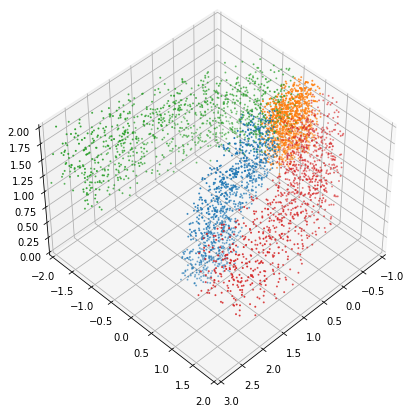

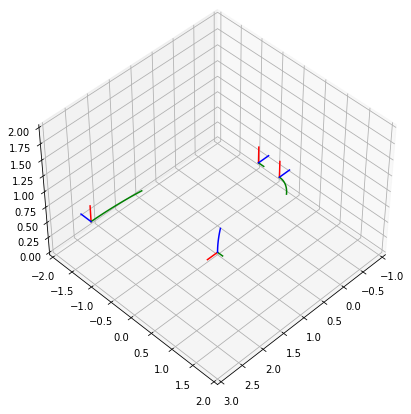

In [10]:
geom1, geom2, geom3, geom4 = create_geometry(rnd_key)
geoms = [geom1, geom2, geom3, geom4]

pts1,_ = geom1.importance_sampling(1000)
pts2,_ = geom2.importance_sampling(1000)
pts3,_ = geom3.importance_sampling(1000)
pts4,_ = geom4.importance_sampling(1000)

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(pts1[:,0], pts1[:,1], pts1[:,2], s = 1)
ax.scatter3D(pts2[:,0], pts2[:,1], pts2[:,2], s = 1)
ax.scatter3D(pts3[:,0], pts3[:,1], pts3[:,2], s = 1)
ax.scatter3D(pts4[:,0], pts4[:,1], pts4[:,2], s = 1)
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-2,2)
ax.axes.set_zlim3d(0,2)
ax.view_init(45,45)

yspace= np.linspace(-1,-0.5,100)

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
for g in geoms:
    ys = np.concatenate((yspace[...,None], yspace[...,None]*0-1, yspace[...,None]*0-1),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'red')
    
    ys = np.concatenate((yspace[...,None]*0-1, yspace[...,None], yspace[...,None]*0-1),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'green')
    
    ys = np.concatenate((yspace[...,None]*0-1, yspace[...,None]*0-1, yspace[...,None]),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'blue')
    
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-2,2)
ax.axes.set_zlim3d(0,2)
ax.view_init(45,45)


### Construct the neural network model

For every of the 4 subdomain, a neural network is used. Moreover, for the 3 interfaces, additional neural networks are defined.

In [15]:
def interface_function3d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**1/(endpositive-endzero)**1)
    if nd == 0:
        fret = lambda ws, x, *params: (nn(ws, jnp.concatenate((x[...,1][...,None],x[...,2][...,None]),-1), *params)*faux(x[...,0])[...,None])
    elif nd==1:
        fret = lambda ws, x, *params: (nn(ws, jnp.concatenate((x[...,0][...,None],x[...,2][...,None]),-1), *params)*faux(x[...,1])[...,None])
    elif nd==2:
        fret = lambda ws, x, *params: (nn(ws, jnp.concatenate((x[...,0][...,None],x[...,1][...,None]),-1), *params)*faux(x[...,2])[...,None])
    else: 
        raise Exception("nd must be 0,1 or 2.")
    return fret

def interface_function1d(dembedding: int, dim: int, zeros: list[int], ones: list[int], nn: callable, alpha: float = 1.0) -> callable:

    faux = lambda y,one,zero: ((y-zero)**alpha/(one-zero)**alpha)

    if dembedding==3:
        dims = list(set(range(dembedding)) - {dim})
        fret = lambda ws, x, *params: (nn(ws, x[...,dim][...,None], *params)*faux(x[...,dims[0]],ones[0],zeros[0])[...,None]*faux(x[...,dims[1]],ones[1],zeros[1])[...,None])

    return fret


def jump_function3d(nd, pos_y, nn):

    faux = lambda x: jnp.exp(-4.0*jnp.abs(x-pos_y))
    if nd == 1:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def monom(x: jax.numpy.array, d: int, bound: float, deg: float = 1.0, out_dims: int = 1):
    return jnp.tile(((x[...,d]-bound)**deg)[...,None],out_dims)

# def ExpHat(hidden_size, out_dim, W_init=glorot_normal(), b_init=normal()):
#   """Layer constructor function for a dense (fully-connected) layer."""
#   def init_fun(rng, input_shape):
#     output_shape = input_shape[:-1] + (out_dim,)
#     k1, k2 = random.split(rng)
#     W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
#     return output_shape, (W, b)
#   def apply_fun(params, inputs, **kwargs):
#     b, b = params
#     return jnp.dot(inputs, W) + b
#   return init_fun, apply_fun
def ExpHat(x, scale = 0.1):
    return jnp.exp(-jnp.abs(x)/scale)

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        nl = 10
        NP = 6
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)

        w_init = jax.nn.initializers.normal()
        
        block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
        block_first = stax.serial(stax.FanInConcat(),stax.Dense(nl, W_init = w_init,b_init=jax.nn.initializers.zeros),acti)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
        
        self.add_neural_network_param('u1',stax.serial(block_first,block,block, block, stax.Dense(3)), ((-1,3),(-1,NP))) # leg
        self.add_neural_network_param('u2',stax.serial(block_first,block,block, block, stax.Dense(3)), ((-1,3),(-1,NP))) # split
        self.add_neural_network_param('u3',stax.serial(block_first,block,block, block, stax.Dense(3)), ((-1,3),(-1,NP))) # arm left
        self.add_neural_network_param('u4',stax.serial(block_first,block,block, block, stax.Dense(3)), ((-1,3),(-1,NP))) # arm right
        self.add_neural_network_param('u12',stax.serial(block_first,block,block, block, stax.Dense(3)),((-1,2),(-1,NP))) 
        self.add_neural_network_param('u23',stax.serial(block_first,block,block, block, stax.Dense(3)),((-1,2),(-1,NP))) 
        self.add_neural_network_param('u24',stax.serial(block_first,block,block, block, stax.Dense(3)),((-1,2),(-1,NP))) 
        
        self.interface12 = interface_function3d(2, 1.0, -1.0, self.neural_networks['u12'])
        self.interface21 = interface_function3d(2, -1.0, 1.0, self.neural_networks['u12'])
        self.interface123 = interface_function1d(3, 0, [-1,1],[1,-1], lambda ws, y, *extra: self.neural_networks['u12'](ws, jnp.concatenate((y,y*0-1),-1), *extra))
        self.interface124 = interface_function1d(3, 0, [1,1],[-1,-1], lambda ws, y, *extra: self.neural_networks['u12'](ws, jnp.concatenate((y,y*0+1),-1), *extra))

        self.interface23 = interface_function3d(1, -1.0, 1.0, self.neural_networks['u23'])
        self.interface32 = interface_function3d(1, 1.0, -1.0, self.neural_networks['u23'])
        self.interface231 = interface_function1d(3, 0, [1,-1],[-1,1], lambda ws, y, *extra: self.neural_networks['u23'](ws, jnp.concatenate((y,y*0-1),-1), *extra))

        self.interface24 = interface_function3d(1, 1.0, -1.0, self.neural_networks['u24'])
        self.interface42 = interface_function3d(1, -1.0, 1.0, self.neural_networks['u24'])
        self.interface241 = interface_function1d(3, 0, [-1,-1],[1,1], lambda ws, y, *extra: self.neural_networks['u24'](ws, jnp.concatenate((y,y*0-1),-1), *extra))

        self.points = self.get_points_MC(10000, self.key)
        
        E = 0.02e5
        nu = 0.1
        self.E = E
        self.nu = nu
        
        self.lamda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)
        
        rho = 0.1
        g = 9.81
        self.rho = rho
        
        self.f = np.array([0,0,-g*rho])
        
        
    def get_points_MC(self, N, key):        

        points = {}

        NP = 6

        ys = jax.random.uniform(key ,(N,3))*2-1
        Weights = jnp.ones((N,))*4/ys.shape[0]
        ps = jax.random.uniform(key ,(N,NP))*2-1
        
        # ys = np.array(jax.random.uniform(self.key, (N,2)))*2-1
        # Weights = jnp.ones((N,))*4/ys.shape[0]

        points['ps'] = ps
        
        points['ys1'] = ys
        points['ws1'] = Weights
        points['omega1'], points['G1'], points['K1'] = geom1.GetMetricTensors(ys,ps)
       
        points['ys2'] = ys
        points['ws2'] = Weights
        points['omega2'], points['G2'], points['K2'] = geom2.GetMetricTensors(ys,ps)
        
        points['ys3'] = ys
        points['ws3'] = Weights
        points['omega3'], points['G3'], points['K3'] = geom3.GetMetricTensors(ys,ps)
        
        points['ys4'] = ys
        points['ws4'] = Weights
        points['omega4'], points['G4'], points['K4'] = geom4.GetMetricTensors(ys,ps)

        return points


    def solution1(self, ws, y, ps):
        # iron
        u = self.neural_networks['u1'](ws['u1'],y,ps)
        v = monom(y,2,-1,out_dims = 3)*monom(y,2,1, out_dims = 3)
        w = self.interface12(ws['u12'],y,ps)+self.interface231(ws['u23'], y, ps)+self.interface241(ws['u24'], y, ps)
        
        return u*v+w

    def solution2(self, ws, y, ps):
        # iron
        u = self.neural_networks['u2'](ws['u2'],y, ps)
        v = monom(y,1,-1,out_dims = 3)*monom(y,1,1, out_dims = 3)*monom(y,2,-1, out_dims = 3)
        w =   self.interface21(ws['u12'],y, ps)+self.interface23(ws['u23'],y, ps)+self.interface24(ws['u24'],y, ps)
        
        
        return u*v+w

    def solution3(self, ws, y, ps):
        # iron
        u = self.neural_networks['u3'](ws['u3'],y, ps)
        v = monom(y,1,1,out_dims = 3)
        w = self.interface32(ws['u23'],y, ps)+self.interface123(ws['u12'], y, ps)
        
        return u*v+w
    
    def solution4(self, ws, y, ps):
        # iron
        u = self.neural_networks['u4'](ws['u4'],y, ps)
        v = monom(y,1,-1,out_dims = 3)
        w = self.interface42(ws['u24'],y, ps)+self.interface124(ws['u12'], y, ps)
        
        return u*v+w


    def loss_pde(self, ws, points):
        jacs1 = pinns.operators.jacobian(lambda x,p : self.solution1(ws,x,p))(points['ys1'], points['ps'])
        jacs2 = pinns.operators.jacobian(lambda x,p : self.solution2(ws,x,p))(points['ys2'], points['ps'])
        jacs3 = pinns.operators.jacobian(lambda x,p : self.solution3(ws,x,p))(points['ys3'], points['ps'])
        jacs4 = pinns.operators.jacobian(lambda x,p : self.solution4(ws,x,p))(points['ys4'], points['ps'])
        
        jacs_x1 = jnp.einsum('mij,mjk->mik', jacs1, points['G1'])
        jacs_x2 = jnp.einsum('mij,mjk->mik', jacs2, points['G2'])
        jacs_x3 = jnp.einsum('mij,mjk->mik', jacs3, points['G3'])
        jacs_x4 = jnp.einsum('mij,mjk->mik', jacs4, points['G4'])

        divs_x1 = (jacs_x1[...,0,0] + jacs_x1[...,1,1] + jacs_x1[...,2,2])[...,None]
        divs_x2 = (jacs_x2[...,0,0] + jacs_x2[...,1,1] + jacs_x2[...,2,2])[...,None]
        divs_x3 = (jacs_x3[...,0,0] + jacs_x3[...,1,1] + jacs_x3[...,2,2])[...,None]
        divs_x4 = (jacs_x4[...,0,0] + jacs_x4[...,1,1] + jacs_x4[...,2,2])[...,None]
        
        strain1 = 0.5 * (jacs_x1 + jnp.transpose(jacs_x1,[0,2,1]))
        strain2 = 0.5 * (jacs_x2 + jnp.transpose(jacs_x2,[0,2,1]))
        strain3 = 0.5 * (jacs_x3 + jnp.transpose(jacs_x3,[0,2,1]))
        strain4 = 0.5 * (jacs_x4 + jnp.transpose(jacs_x4,[0,2,1]))
        
        stress1 = self.lamda * (1+points['ps'][...,0]*0.1)[...,None,None] * jnp.einsum('ij,jkl->ikl', divs_x1, jnp.eye(3)[None,...]) + 2 * self.mu * (1+points['ps'][...,1]*0.1)[...,None,None] * strain1
        stress2 = self.lamda * (1+points['ps'][...,0]*0.1)[...,None,None] * jnp.einsum('ij,jkl->ikl', divs_x2, jnp.eye(3)[None,...]) + 2 * self.mu * (1+points['ps'][...,1]*0.1)[...,None,None] * strain2
        stress3 = self.lamda * (1+points['ps'][...,2]*0.1)[...,None,None] * jnp.einsum('ij,jkl->ikl', divs_x3, jnp.eye(3)[None,...]) + 2 * self.mu * (1+points['ps'][...,3]*0.1)[...,None,None] * strain3
        stress4 = self.lamda * (1+points['ps'][...,4]*0.1)[...,None,None] * jnp.einsum('ij,jkl->ikl', divs_x4, jnp.eye(3)[None,...]) + 2 * self.mu * (1+points['ps'][...,5]*0.1)[...,None,None] * strain4
        
        

        a1 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress1, strain1), points['ws1'] * points['omega1']) 
        a2 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress2, strain2), points['ws2'] * points['omega2']) 
        a3 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress3, strain3), points['ws3'] * points['omega3']) 
        a4 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress4, strain4), points['ws4'] * points['omega4']) 
        rhs1 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution1(ws,points['ys1'], points['ps'])), points['omega1'] * points['ws1'])
        rhs2 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution2(ws,points['ys2'], points['ps'])), points['omega2'] * points['ws2'])
        rhs3 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution3(ws,points['ys3'], points['ps'])), points['omega3'] * points['ws3'])
        rhs4 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution4(ws,points['ys4'], points['ps'])), points['omega4'] * points['ws4'])
        
        return a1+a2+a3+a4-rhs1-rhs2-rhs3-rhs4

    def loss(self, ws, pts):
        lpde = self.loss_pde(ws, pts)
        return lpde


### Train the model

The user can choose between the ADAM and the LBFGS optimizers by setting the `opt_type` variable.

In [16]:


rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

dev = jax.devices('gpu')[1]

# loss_compiled = jax.jit(model.loss_handle, device = jax.devices()[0])
# lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[0])
# 
# def loss_grad(w):
#     l, gr = lossgrad_compiled(jnp.array(w))
#     return np.array( l.to_py() ), np.array( gr.to_py() )



batch_size = 10000

get_compiled = jax.jit(lambda key: model.get_points_MC(batch_size, key), device = dev)
%time pts = get_compiled(jax.random.PRNGKey(1235))
%time pts = get_compiled(jax.random.PRNGKey(1111))

lr_opti = optimizers.piecewise_constant([2000,4000,6000,8000,12000], [0.01, 0.005, 0.001, 0.0005,0.0001,0.00001])
opt_init, opt_update, get_params = optimizers.adam(lr_opti)

opt_state = opt_init(weights)

# get initial parameters
params = get_params(opt_state)

loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

def step(params, opt_state, key):
    # points = model.get_points_MC(5000)
    points = model.get_points_MC(batch_size, key)
    loss, grads = loss_grad(params, points)
    opt_state = opt_update(0, grads, opt_state)

    params = get_params(opt_state)
    
    return params, opt_state, loss

step_compiled = jax.jit(step, device = dev)
step_compiled(params, opt_state, rnd_key)

n_epochs = 5000

hist = []

tme = datetime.datetime.now()
for k in range(n_epochs):    
    params, opt_state, loss = step_compiled(params, opt_state, jax.random.PRNGKey(np.random.randint(32131233123)))
    
    hist.append(loss)
    
    print('Epoch %d/%d - loss value %e'%(k+1, n_epochs, loss))
# update params
model.weights = params
weights = params
tme = datetime.datetime.now() - tme
print('Elapsed time ', tme)


CPU times: user 29.9 s, sys: 307 ms, total: 30.2 s
Wall time: 26.4 s
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 11.2 ms
Epoch 1/5000 - loss value 6.480821e+00
Epoch 2/5000 - loss value 1.772240e+01
Epoch 3/5000 - loss value 2.271715e+01
Epoch 4/5000 - loss value 9.652979e+00
Epoch 5/5000 - loss value 7.040941e+00
Epoch 6/5000 - loss value 9.183461e+00
Epoch 7/5000 - loss value 2.623694e+00
Epoch 8/5000 - loss value 7.671777e+00
Epoch 9/5000 - loss value 2.716477e+00
Epoch 10/5000 - loss value 2.632055e+00
Epoch 11/5000 - loss value 4.416726e+00
Epoch 12/5000 - loss value 2.548229e+00
Epoch 13/5000 - loss value 1.592962e+00
Epoch 14/5000 - loss value 1.732726e+00
Epoch 15/5000 - loss value 1.993932e+00
Epoch 16/5000 - loss value 1.580386e+00
Epoch 17/5000 - loss value 1.137125e+00
Epoch 18/5000 - loss value 9.194421e-01
Epoch 19/5000 - loss value 8.377336e-01
Epoch 20/5000 - loss value 1.028506e+00
Epoch 21/5000 - loss value 8.800015e-01
Epoch 22/5000 - loss value 4.6

### Post-processing

Plot the absolute value of the strain along the $y_2y_3$-planes.

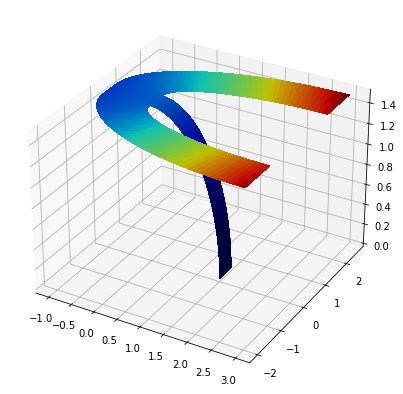

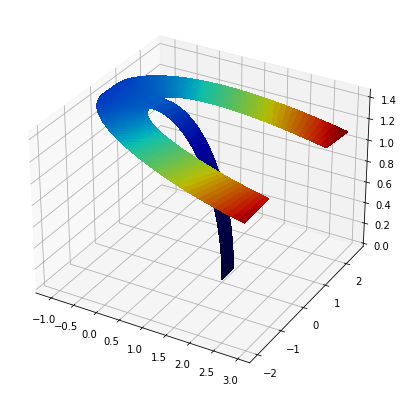

In [17]:
from matplotlib import cm
YS = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
ps = jnp.zeros((100**2,6))


ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs1 = geom1(ys)
Us1 = model.solution1(weights, ys, ps)
Z1 = np.linalg.norm(Us1,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs2 = geom2(ys)
Us2 = model.solution2(weights, ys, ps)
Z2 = np.linalg.norm(Us2,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs3 = geom3(ys)
Us3 = model.solution3(weights, ys, ps)
Z3 = np.linalg.norm(Us3,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs4 = geom4(ys)
Us4 = model.solution4(weights, ys, ps)
Z4 = np.linalg.norm(Us4,axis=-1).reshape(YS[0].shape)

Zmax = max([np.amax(Z1), np.amax(Z2), np.amax(Z3), np.amax(Z4)])

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
my_col = cm.jet(Z1/Zmax)
ax.plot_surface(Xs1[:,0].reshape(YS[0].shape), Xs1[:,1].reshape(YS[0].shape), Xs1[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z2/Zmax)
ax.plot_surface(Xs2[:,0].reshape(YS[0].shape), Xs2[:,1].reshape(YS[0].shape), Xs2[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z3/Zmax)
ax.plot_surface(Xs3[:,0].reshape(YS[0].shape), Xs3[:,1].reshape(YS[0].shape), Xs3[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z4/Zmax)
ax.plot_surface(Xs4[:,0].reshape(YS[0].shape), Xs4[:,1].reshape(YS[0].shape), Xs4[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)


plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
my_col = cm.jet(Z1/Zmax)
ax.plot_surface((Xs1+Us1)[:,0].reshape(YS[0].shape), (Xs1+Us1)[:,1].reshape(YS[0].shape), (Xs1+Us1)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z2/Zmax)
ax.plot_surface((Xs2+Us2)[:,0].reshape(YS[0].shape), (Xs2+Us2)[:,1].reshape(YS[0].shape), (Xs2+Us2)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z3/Zmax)
ax.plot_surface((Xs3+Us3)[:,0].reshape(YS[0].shape), (Xs3+Us3)[:,1].reshape(YS[0].shape), (Xs3+Us3)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z4/Zmax)
ax.plot_surface((Xs4+Us4)[:,0].reshape(YS[0].shape), (Xs4+Us4)[:,1].reshape(YS[0].shape), (Xs4+Us4)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

# ys = np.concatenate((YS[0].flatten()[...,None], YS[0].flatten()[...,None]*0, YS[1].flatten()[...,None]),-1)
# Us = model.solution2(weights, ys)
# Us2 = Us
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')
# 
# Xs = geom3(ys)
# Us = model.solution3(weights, ys)
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')
# 
# Xs = geom4(ys)
# Us = model.solution4(weights, ys)
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# #ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')

Plot the deformation of the domains. The solutions and the geometry objects are JITed first.

In [18]:
solutions = [jax.jit(model.solution1), jax.jit(model.solution2), jax.jit(model.solution3), jax.jit(model.solution4)]
geoms = [jax.jit(g) for g in geoms]

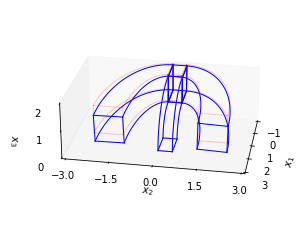

In [20]:
ys = jnp.linspace(-1,1,100)[...,None]
Ys  = [jnp.concatenate((ys,ys*0-1,ys*0-1), -1)]
Ys += [jnp.concatenate((ys,ys*0-1,ys*0+1), -1)]
Ys += [jnp.concatenate((ys,ys*0+1,ys*0-1), -1)]
Ys += [jnp.concatenate((ys,ys*0+1,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys,ys*0-1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0+1,ys,ys*0-1), -1)]
Ys += [jnp.concatenate((ys*0+1,ys,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys*0-1,ys), -1)]
Ys += [jnp.concatenate((ys*0-1,ys*0+1,ys), -1)]
Ys += [jnp.concatenate((ys*0+1,ys*0-1,ys), -1)]
Ys += [jnp.concatenate((ys*0+1,ys*0+1,ys), -1)]

plt.figure()
ax = plt.axes(projection ="3d")




for i in range(4):
    for k in range(12):
        Xs = geoms[i](Ys[k])
        Us = solutions[i](weights, Ys[k], jnp.zeros((Ys[k].shape[0],6)))
        ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'red',linewidth = 1,alpha=0.2)
        ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue',linewidth = 1)
      
ax.grid(False)  
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-3,3)
ax.axes.set_zlim3d(0,2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.set_zticks([0,1,2])
ax.set_xticks([-1,0,1,2,3])
ax.set_yticks([-3,-1.5,0,1.5,3])
ax.view_init(25,10)
ax.set_box_aspect(aspect = (4,6,2))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('./elasto_3d.pdf',bbox_inches='tight')

